In [136]:
import pandas as pd
import numpy as np
import re
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import warnings
warnings.filterwarnings('ignore')
import os
basePath = '/Users/ravipanguluri/Documents/newNobelPrizeScraper/'
print(os.getcwd())
from pandas.plotting import table
import seaborn as sns
import dataframe_image as dfi
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline
%autosave 120

/Users/ravipanguluri/Documents/newNobelPrizeScraper


Autosaving every 120 seconds


In [41]:
nobel_data = pd.read_json('nobel_data.json')
nobel_data['is_winner'] = nobel_data['prize_status'].notnull()

#Dealing with input errors from data, where nonsense character is assigned to gender
nobel_data.loc[(nobel_data['Gender'] != 'M') & (nobel_data['Gender'] != 'F'), 'Gender'] = 'M'
nobel_data.loc[(nobel_data['Country'] == 'GERMANY (DE)  GERMANY (DE) '), 'Country'] = 'GERMANY (DE) '
nobel_data.loc[(nobel_data['Country'] == 'FRANCE (FR)  FRANCE (FR) '), 'Country'] = 'FRANCE (FR) '

nobel_data

,url,category,year,role,Name,City,Country,Gender,Profession,"Year, Birth","Year, Death",University,prize_status,State,Department,is_winner
0,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1959,Nominee,Women´s International League for Peace and F...,Geneva,SWITZERLAND (CH),M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1959,Nominator,Inger Segerstedt Wiberg,NaN,SWEDEN (SE),F,Member of Parliament,NaN,NaN,NaN,NaN,NaN,NaN,False
2,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1901,Nominee,William W Campbell,NaN,UNITED STATES (US),M,NaN,1862.0,1938.0,NaN,NaN,NaN,NaN,False
3,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1901,Nominee,Svante A Arrhenius,Stockholm,SWEDEN (SE),M,NaN,1859.0,1927.0,Stockholm University,Awarded the Nobel Prize in Chemistry,NaN,NaN,True
4,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1901,Nominee,Svante A Arrhenius,Stockholm,SWEDEN (SE),M,NaN,1859.0,1927.0,Stockholm University,Awarded the Nobel Prize in Chemistry,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40934,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominator,2 members of Yugoslav parliament,NaN,YUGOSLAVIA (YU),M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
40935,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominee,Norman Thomas,NaN,UNITED STATES (US),M,American politician,1884.0,1968.0,NaN,NaN,NaN,NaN,False
40936,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominator,John P Roche,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
40937,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominee,World Veterans Federation (Fédération Mondia...,Paris,FRANCE (FR),M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


The dataset includes all relevant information for every nomination in the database of nobel prize nominations from the nobel prize nomination archive. Each row represents a nominee or a nominator, the specific nomination that they are giving or receiving (year/category) and background info on the person including name, birth year, death, nationality, city, university, and profession

In [238]:
nominators = nobel_data[nobel_data['role'] == "Nominator"]
nominees = nobel_data[nobel_data['role'] == "Nominee"]
orig_len_nominators = len(nominators.index)
orig_len_nominees = len(nominees.index)

def checkMultipleCountries(country):
    if (len(re.findall(r'\(\w+\)', country)) == 1) | ( (len(re.findall(r'\(\w+\)', country)) == 2) & ("now" in country) ):
        return country

'''filtering out all observations with multiple countries in country tag as these repeat observations have varying
reasons for being erroneous and there is simply no clean way to design a filter to capture meaningful observations.
For instance, some multiple country instances are due to multiple nominators being reported as one, but there are others
that have much less clear reasons for existing. Going through and checking them one by one is not feasible, so filtering them out was the best
solution'''
valid_countries_nominators = np.unique(list(filter(checkMultipleCountries, nominators['Country'].astype(str))))
valid_countries_nominees = np.unique(list(filter(checkMultipleCountries, nominees['Country'].astype(str))))

nominators['invalid_country'] = ~nominators['Country'].isin(valid_countries_nominators) & nominators['Country'].notnull()
nominees['invalid_country'] = ~nominees['Country'].isin(valid_countries_nominees) & nominees['Country'].notnull()

print(f"Percentage of nominators flagged: {(nominators['invalid_country'].sum() * 100) /len(nominators.index):.3f}%")
print(f"Percentage of nominees flagged: {(nominees['invalid_country'].sum() * 100) /len(nominees.index):.3f}%")

Percentage of nominators flagged: 0.192%
Percentage of nominees flagged: 0.149%


In [43]:
unique_nominees = nominees.drop_duplicates(subset=['Name'])
num_winners = unique_nominees['is_winner'].sum()
print("Number of winners: ",num_winners)
print("Winning %: ",(num_winners/len(nominees.index)) *100)
print("Proportion of Nominees Who Have Ever Won the Prize: ",num_winners/len(unique_nominees.index) *100)

Number of winners:  373
Winning %:  1.6842010204542377
Proportion of Nominees Who Have Ever Won the Prize:  11.438209138301135


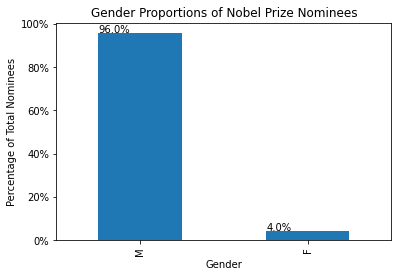

In [114]:
fig, ax = plt.subplots(1,1)
unique_nominees['Gender'].value_counts(normalize = True).plot(kind = 'bar', ax=ax)

for p in ax.patches:
    txt = np.round(p.get_height(), decimals=2) * 100
    ax.annotate(str(txt)+"%", (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_title("Gender Proportions of Nobel Prize Nominees")
ax.set_xlabel("Gender")
ax.set_ylabel("Percentage of Total Nominees")
ax.yaxis.set_major_formatter(PercentFormatter(1))
fig.savefig('gender_proportions_of_nobel_prize_nominees.png')

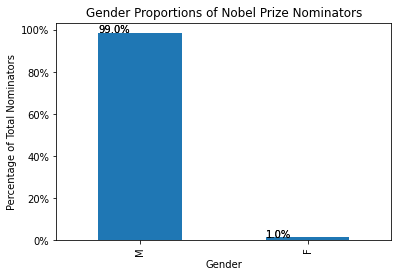

In [115]:
unique_nominators = nominators.drop_duplicates(subset=['Name'])

fig, ax = plt.subplots(1,1)
unique_nominators['Gender'].value_counts(normalize = True).plot(kind = 'bar', ax = ax)
for p in ax.patches:
    for p in ax.patches:
        txt = np.round(p.get_height(), decimals=2) * 100
        ax.annotate(str(txt)+"%", (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_title("Gender Proportions of Nobel Prize Nominators")
ax.set_xlabel("Gender")
ax.set_ylabel("Percentage of Total Nominators")
ax.yaxis.set_major_formatter(PercentFormatter(1))
fig.savefig('gender_proportions_of_nobel_prize_nominators.png')

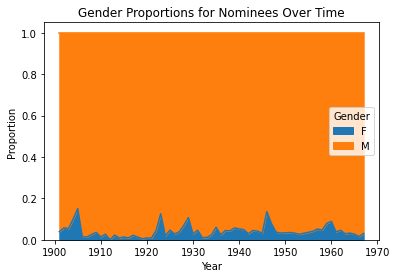

In [116]:
fig, ax = plt.subplots(1,1)
nominees_gender = nominees.groupby('year')['Gender'].value_counts(normalize=True).unstack()
nominees_gender.plot(kind ='area', legend = True, ax=ax)
ax.set_title("Gender Proportions for Nominees Over Time")
ax.set_ylabel("Proportion")
ax.set_xlabel("Year")
fig.savefig('gender_proportions_of_nobel_prize_nominees_over_time.png')

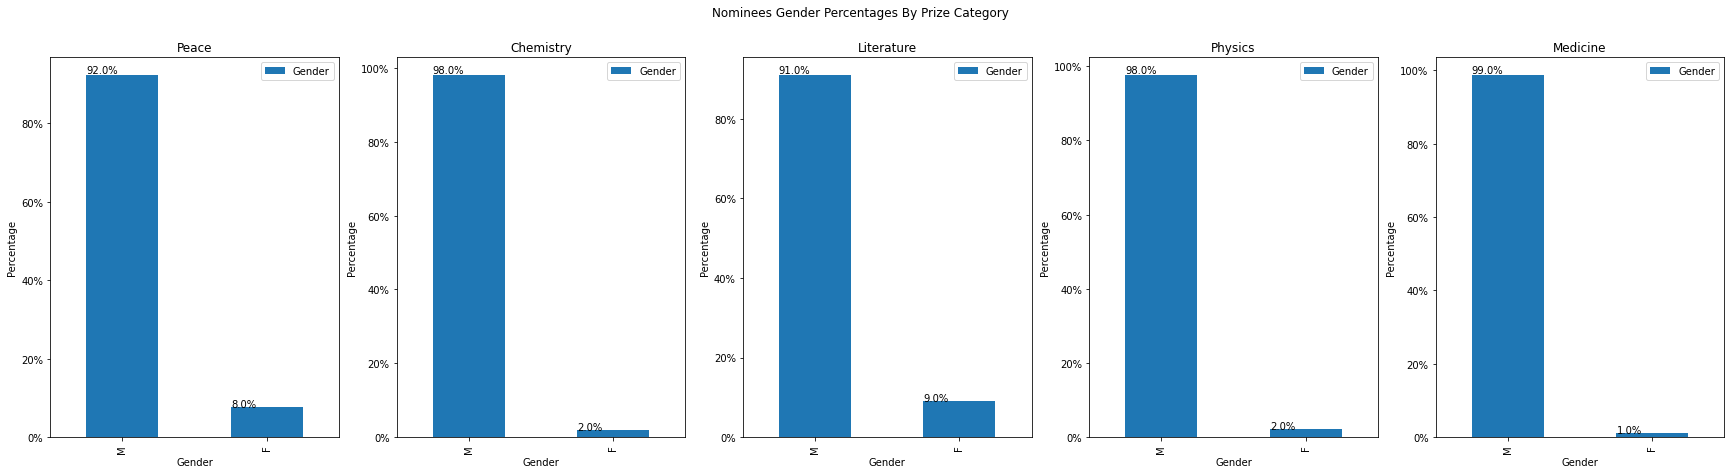

In [48]:
fig, axes = plt.subplots(1,5, figsize = (30,7))
fig.suptitle("Nominees Gender Percentages By Prize Category")

nominees_grouped = nominees.groupby('category')
# nominees.groupby('category')['Gender'].value_counts(normalize = True).unstack().plot(kind = 'bar', legend = True, ax=ax)
plot_areas = zip(nominees_grouped.groups.keys(), axes.flatten()) # creates list so that I can match plotting axes with group keys when I iterate

#Helper function to fix string formatting
def getSubtitle(key):
    if "Peace" in key:
        return "Peace"
    else:
        return key.split(" ")[-1]

for idx, (key, ax) in enumerate(plot_areas):
    group = nominees_grouped.get_group(key)
    subtitle = getSubtitle(key)
    group['Gender'].value_counts(normalize = True).plot(kind = 'bar', legend = True, ax=ax)
    ax.set_title(subtitle)
    ax.set_xlabel("Gender")
    ax.set_ylabel("Percentage")
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    for p in ax.patches:
        txt = np.round(p.get_height(), decimals=2) * 100
        ax.annotate(str(txt)+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'Nominee_Gender_Proportions_{subtitle}.png', bbox_inches=extent.expanded(1.1, 1.2))

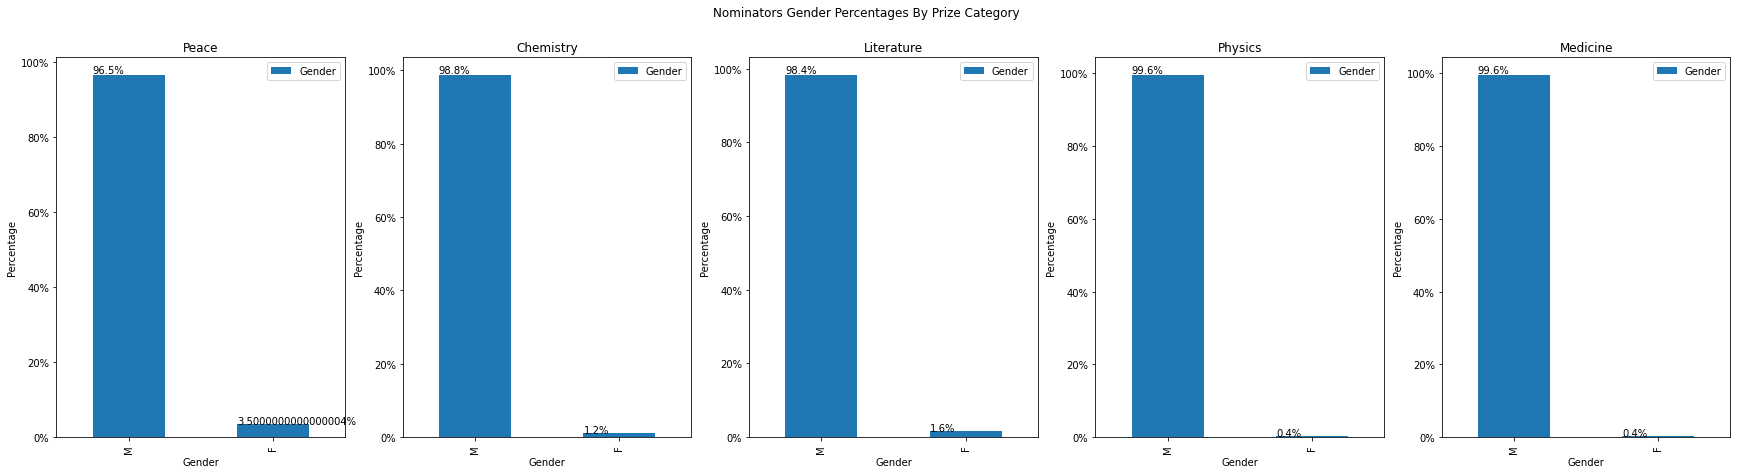

In [49]:
fig, axes = plt.subplots(1,5, figsize = (30,7))
fig.suptitle("Nominators Gender Percentages By Prize Category")

nominators_grouped = nominators.groupby('category')
# nominees.groupby('category')['Gender'].value_counts(normalize = True).unstack().plot(kind = 'bar', legend = True, ax=ax)
plot_areas = zip(nominators_grouped.groups.keys(), axes.flatten()) # creates list so that I can match plotting axes with group keys when I iterate

for idx, (key, ax) in enumerate(plot_areas):
    group = nominators_grouped.get_group(key)
    subtitle = getSubtitle(key)
    group['Gender'].value_counts(normalize = True).plot(kind = 'bar', legend = True, ax=ax)
    ax.set_title(subtitle)
    ax.set_xlabel("Gender")
    ax.set_ylabel("Percentage")
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    for p in ax.patches:
    	txt = np.round(p.get_height(), decimals=3) * 100
    	ax.annotate(str(txt)+"%", (p.get_x() * 1.005, p.get_height() * 1.005))
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'Nominator_Gender_Proportions_{subtitle}.png', bbox_inches=extent.expanded(1.1, 1.2))

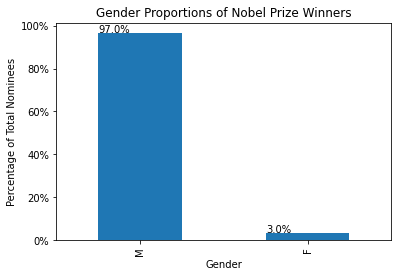

In [117]:
winners = unique_nominees[unique_nominees['is_winner'] == True]

fig, ax = plt.subplots(1,1)
winners['Gender'].value_counts(normalize = True).plot(kind = 'bar', ax=ax)

for p in ax.patches:
    txt = np.round(p.get_height(), decimals=2) * 100
    ax.annotate(str(txt)+"%", (p.get_x() * 1.005, p.get_height() * 1.005))

ax.set_title("Gender Proportions of Nobel Prize Winners")
ax.set_xlabel("Gender")
ax.set_ylabel("Percentage of Total Nominees")
ax.yaxis.set_major_formatter(PercentFormatter(1))
fig.savefig('gender_proportions_of_nobel_prize_winners.png')

In [118]:
nominators.describe()
unique_nominators = nominators.drop_duplicates(subset = ['Name'])
unique_nominators.describe()

,year,"Year, Birth","Year, Death"
count,9902.000000,1282.000000,1150.000000
mean,1935.619168,1887.968019,1968.587826
std,19.996219,26.609585,27.170810
min,1901.000000,1647.000000,1885.000000
25%,1920.000000,1869.000000,1951.000000
50%,1935.000000,1894.000000,1973.000000
75%,1953.000000,1907.000000,1989.000000
max,1967.000000,1956.000000,2017.000000


In [52]:
nominees.describe()

,year,"Year, Birth","Year, Death"
count,22147.000000,18225.000000,16785.000000
mean,1935.733824,1877.929712,1956.947036
std,19.591170,24.037674,25.266414
min,1901.000000,1647.000000,1901.000000
25%,1920.000000,1861.000000,1938.000000
50%,1935.000000,1878.000000,1960.000000
75%,1953.000000,1896.000000,1974.000000
max,1967.000000,1987.000000,2019.000000


In [154]:
nominees_people = nominees[nominees['category'] != "Nomination for Nobel Peace Prize"] #filtering out category where organizations are often nominated
nominees_people.describe()

def getAge(birth, nom_year):
    return nom_year - birth;
def getAgeDeath(birth, death):
    return death - birth;

'''Every single column in which the age is negative has to do with an error when typing the nomination where a year in the 1900's was put instead of the 1800's. 
In this case, all the birth years are off by exactly 100 years.'''
    
nominees_people.loc[nominees_people['Year, Birth'] > nominees_people['Year, Death'], 'Year, Birth'] = nominees_people['Year, Birth'].sub(100)        
nominees_people['is_dead'] = nominees_people['Year, Death'].notnull()
nominees_people['age'] = getAge(nominees_people['Year, Birth'], nominees_people['year'])
nominees_people['age_death'] = getAgeDeath(nominees_people['Year, Birth'], nominees_people['Year, Death'])
nominees_people_unique = nominees_people.drop_duplicates(subset = ['Name'])

In [251]:
df = nominees_people['age'].describe().to_frame()
dfi.export(df, 'nominees_age_summary.png')
df

[0118/143654.322978:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0118/143654.324092:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0118/143654.325443:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0118/143655.031691:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpol3_esj3/temp.png.


,age
count,14577.000000
mean,56.763189
std,12.127203
min,19.000000
25%,48.000000
50%,56.000000
75%,65.000000
max,97.000000


In [131]:
df = nominees_people_unique['age_death'].describe().to_frame()
# dfi.export(df, 'age_of_death_summary.png')
df

[0117/110324.449836:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/110324.450888:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0117/110324.452415:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/110325.136886:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmp9uqe05t0/temp.png.


,age_death
count,1348.000000
mean,77.915430
std,11.070281
min,33.000000
25%,71.000000
50%,79.000000
75%,86.000000
max,105.000000


[0117/145524.193217:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/145524.194277:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0117/145524.196417:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/145524.837788:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpdtcmq9tr/temp.png.


,years_after_death
count,35.000000
mean,2.942857
std,3.864947
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,18.000000


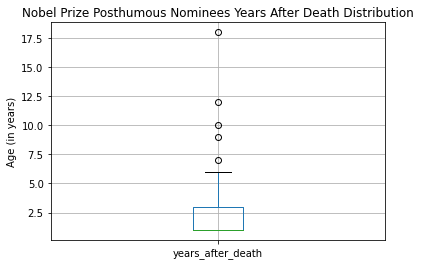

In [155]:
# Posthumous Nominations
nominees_posthumous = nominees_people[nominees_people['year']>nominees_people['Year, Death']]
nominees_posthumous['years_after_death'] = nominees_posthumous['year'] - nominees_posthumous['Year, Death']
nominees_posthumous.boxplot(column = ['years_after_death'])
plt.title("Nobel Prize Posthumous Nominees Years After Death Distribution")
plt.ylabel("Age (in years)")
plt.savefig('nobel_prize_posthumous_nominees_years_after_death_distribution.png')
df = nominees_posthumous['years_after_death'].describe().to_frame()
dfi.export(df, 'years_after_death_summary.png')
df

[0117/150845.404526:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/150845.405565:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0117/150845.406654:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/150846.100514:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpd9u3ae39/temp.png.


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Nomination for Nobel Prize in Chemistry,9.0,4.333333,5.722762,1.0,1.0,2.0,3.0,18.0
Nomination for Nobel Prize in Literature,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
Nomination for Nobel Prize in Physics,9.0,4.666667,4.242641,1.0,1.0,2.0,7.0,12.0
Nomination for Nobel Prize in Physiology or Medicine,16.0,1.312500,0.873212,1.0,1.0,1.0,1.0,4.0


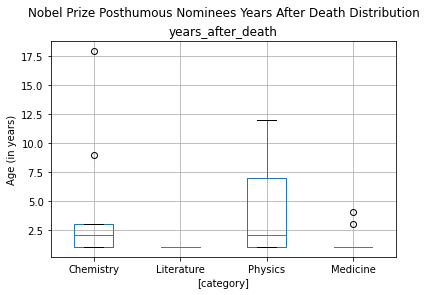

In [164]:
ax = nominees_posthumous.boxplot(column = ['years_after_death'], by = ['category'])
plt.suptitle("Nobel Prize Posthumous Nominees Years After Death Distribution", y = 1.02)
plt.xticks([1, 2, 3, 4], [getSubtitle(cat.get_text()) for cat in ax.get_xticklabels()])
plt.ylabel("Age (in years)")
df = nominees_posthumous.groupby('category')['years_after_death'].describe()
dfi.export(df, 'grouped_posthumous_nominee_summary.png')
df

[0117/113737.737852:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/113737.738919:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0117/113737.739908:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/113738.384953:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmp10ydy3cr/temp.png.


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Nomination for Nobel Prize in Chemistry,263.0,52.456274,11.522174,29.0,44.0,51.0,61.0,81.0
Nomination for Nobel Prize in Literature,538.0,59.440520,11.401313,29.0,52.0,60.0,67.0,91.0
Nomination for Nobel Prize in Physics,315.0,47.965079,11.328704,19.0,40.0,47.0,55.0,83.0
Nomination for Nobel Prize in Physiology or Medicine,197.0,53.502538,10.970101,25.0,47.0,53.0,60.0,84.0


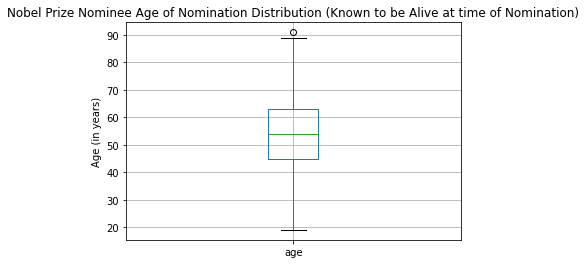

In [137]:
nominees_alive = nominees_people[nominees_people['year']<nominees_people['Year, Death']]
nominees_alive.boxplot(column = ['age'])
plt.title("Nobel Prize Nominee Age of Nomination Distribution (Known to be Alive at time of Nomination)")
plt.ylabel("Age (in years)")
# plt.savefig('nobel_prize_nominee_age_of_nomination_distribution.png')
df = nominees_alive.groupby('category')['age'].describe()
# dfi.export(df, 'nominees_alive_age_by_category_summary.png')
df

[0117/151007.395783:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/151007.396784:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0117/151007.397783:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/151008.049044:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmp0g2wguhw/temp.png.


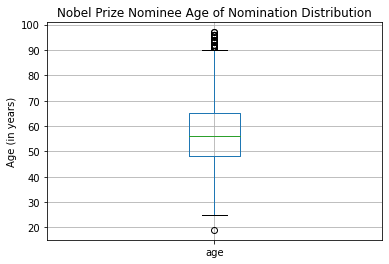

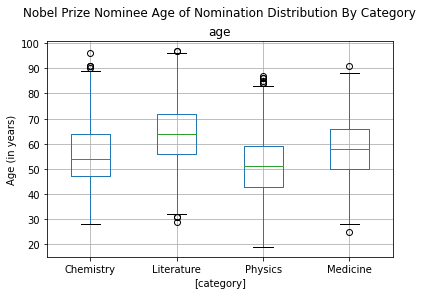

In [165]:
#filtering out all urls of erroneous nominations given to nominees that were known to be dead at the time of nomination
common = nominees_people.merge(nominees_posthumous, on=["url"])
result = nominees_people[~nominees_people.url.isin(common.url)]

#Note: not a lot of the nominees have confirmed births and deaths. Could potentiall build a scraper to get more if possible
result.boxplot(column = ['age'])
plt.title("Nobel Prize Nominee Age of Nomination Distribution")
plt.ylabel("Age (in years)")
plt.savefig('nobel_prize_nominee_age_of_nomination_distribution.png')
ax = result.boxplot(column = ['age'], by = ['category'])
plt.suptitle("Nobel Prize Nominee Age of Nomination Distribution By Category", y = 1.02)
plt.xticks([1, 2, 3, 4], [getSubtitle(cat.get_text()) for cat in ax.get_xticklabels()])
plt.ylabel("Age (in years)")
plt.savefig('nobel_prize_nominee_age_of_nomination_distribution_by_category.png')
result.groupby('category')['age'].describe().dfi.export('nobel_prize_age_by_category_summary.png')

count    12976.000000
mean        56.585465
std         11.945435
min         19.000000
25%         48.000000
50%         56.000000
75%         65.000000
max         97.000000
Name: age, dtype: float64

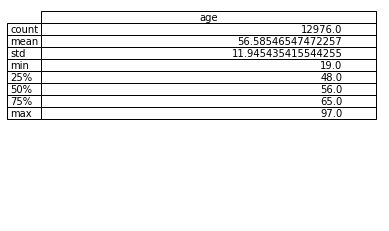

In [60]:
#Just messing around with visualizing tables here
age = nominees_alive['age'].describe()
#create a subplot without frame
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, age,loc='upper right')

#save the plot as a png file
plt.savefig('age_plot.png')
nominees_alive['age'].describe()

,year,"Year, Birth","Year, Death"
count,18792.000000,5229.000000,4912.000000
mean,1935.366379,1879.694397,1960.376221
std,19.709333,24.532483,25.842870
min,1901.000000,1647.000000,1885.000000
25%,1919.000000,1862.000000,1940.000000
50%,1935.000000,1882.000000,1964.000000
75%,1953.000000,1899.000000,1980.000000
max,1967.000000,1956.000000,2017.000000


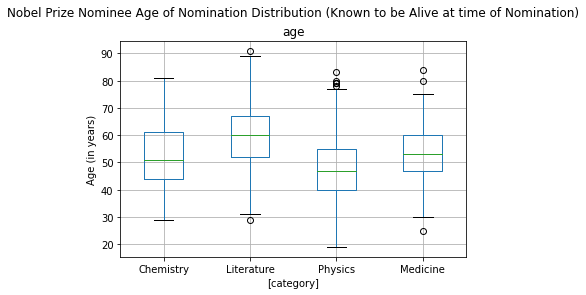

In [166]:
ax = nominees_alive.boxplot(column = ['age'], by = ['category'])
plt.suptitle("Nobel Prize Nominee Age of Nomination Distribution (Known to be Alive at time of Nomination)", y = 1.02)
plt.xticks([1, 2, 3, 4], [getSubtitle(cat.get_text()) for cat in ax.get_xticklabels()])
plt.ylabel("Age (in years)")
nominees_alive.groupby('category')['age'].describe()

nominators.describe()

In [242]:
# NEED TO REPEAT PROCEDURE FOR FULL DATASET
nominators_people = nominators.loc[nominators['Year, Birth'] > 1800] #filtering out non-human nominees where birth year is given
'''Rows contained nominators that somehow made nomiations before they were born.
The reason for these errors was not clear so they were simply dropped from the analysis'''
nominators_people = nominators_people.drop(895)
nominators_people = nominators_people.drop(14083)
nominators_people.loc[nominators_people['Name'] == 'Johan  Vogt', ['Year, Birth', 'Year, Death']] = [1858, 1932]
nominators_people.loc[nominators_people['Name'] == 'Georg  von Rauch', ['Year, Birth', 'Year, Death']] = [1904, 1991]
nominators_people.loc[nominators_people['Name'] == 'Ernst  Schmidt', ['Year, Birth', 'Year, Death']] = [1892, 1975]
nominators_people.loc[nominators_people['Name'] == 'Carel Daniel  Asser jr.', ['Year, Birth', 'Year, Death']] = [1866, 1939]
nominators_people.loc[nominators_people['Name'] == 'Emil  Staiger', 'Year, Birth'] = nominators_people['Year, Birth'] + 100
## Johan Vogt is mistaken for his son also Johan Vogt making his age in the dataset inaccurate. He was born in 1858 and died in 1932
nominators_people.loc[nominators_people['Year, Birth'] > nominators_people['Year, Death'], 'Year, Birth'] = nominators_people['Year, Birth'].sub(100)
nominators_people['age'] = getAge(nominators_people['Year, Birth'], nominators_people['year'])
nominators_people = nominators_people.loc[nominators_people['age'] > 20]
nominators_people = nominators_people.loc[nominators_people['age'] < 100]
nominators_people_unique = nominators_people.drop_duplicates(subset = ['Name'])

[0118/143449.539454:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0118/143449.540619:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0118/143449.541855:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0118/143450.452979:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpz7hhy8hb/temp.png.


,age
count,5215.000000
mean,59.289549
std,11.934603
min,24.000000
25%,51.000000
50%,59.000000
75%,68.000000
max,98.000000


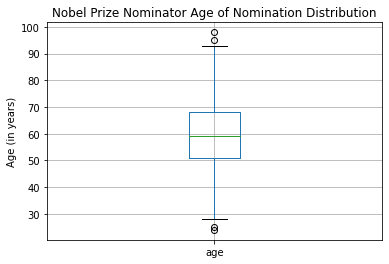

In [249]:
nominators_people.boxplot(column = ['age'])
plt.title("Nobel Prize Nominator Age of Nomination Distribution")
plt.ylabel("Age (in years)")
plt.savefig('nobel_prize_nominator_age_at_nomination.png')
df = nominators_people['age'].describe().to_frame()
dfi.export(df, 'nobel_prize_nominator_age_summary.png')
df

[0117/151643.668645:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/151643.669728:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0117/151643.670777:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/151644.321322:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpux7r63fl/temp.png.


,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Nomination for Nobel Peace Prize,995.0,62.042211,12.770779,30.0,52.0,62.0,72.0,98.0
Nomination for Nobel Prize in Chemistry,1250.0,58.903200,11.163724,29.0,51.0,59.0,67.0,87.0
Nomination for Nobel Prize in Literature,972.0,60.433128,11.055270,32.0,53.0,60.0,67.0,95.0
Nomination for Nobel Prize in Physics,1376.0,56.836483,11.968571,24.0,48.0,56.0,66.0,89.0
Nomination for Nobel Prize in Physiology or Medicine,622.0,59.302251,12.169176,29.0,50.0,59.0,68.0,93.0


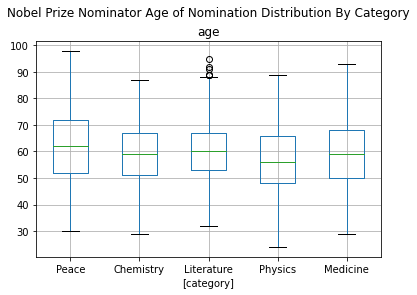

In [170]:
ax = nominators_people.boxplot(column = ['age'], by = ['category'])
plt.suptitle("Nobel Prize Nominator Age of Nomination Distribution By Category", y = 1.02)
plt.xticks([1, 2, 3, 4, 5], [getSubtitle(cat.get_text()) for cat in ax.get_xticklabels()])
plt.savefig('nobel_prize_nominator_age_of_nomination_distribution_by_category.png')
df = nominators_people.groupby('category')['age'].describe()
# dfi.export(df, 'nobel_prize_nominator_age_of_nominations_distribution_by_category.png')
df

In [65]:
female_nominators =  nobel_data.loc[(nobel_data['role'] == 'Nominator') & (nobel_data['Gender'] == 'F')]
female_nominations = female_nominators.merge(
    nominees[nominees.columns[~nominees.columns.isin(['category', 'year'])]], how = 'inner', 
    on = 'url', suffixes = ("_nominator", "_nominee"))
print(f'Proportion of female nominators {(len(female_nominators.index)/len(nominators.index))*100:.3f}%')
female_nominations

Proportion of female nominators 1.485%


,url,category,year,role_nominator,Name_nominator,City_nominator,Country_nominator,Gender_nominator,Profession_nominator,"Year, Birth_nominator",...,Gender_nominee,Profession_nominee,"Year, Birth_nominee","Year, Death_nominee",University_nominee,prize_status_nominee,State_nominee,Department_nominee,is_winner_nominee,invalid_country
0,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1959,Nominator,Inger Segerstedt Wiberg,NaN,SWEDEN (SE),F,Member of Parliament,NaN,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1905,Nominator,Marie Curie,Paris,FRANCE (FR),F,previous winner of a Nobel prize in physics 19...,1867.0,...,M,NaN,1856.0,1940.0,University of Cambridge,Awarded the Nobel Prize in Physics,NaN,NaN,True,False
2,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1910,Nominator,Marie Curie,Paris,FRANCE (FR),F,member of the Royal Swedish Academy of Science...,1867.0,...,M,NaN,1854.0,NaN,NaN,NaN,NaN,NaN,False,False
3,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1956,Nominator,Hertha Sponer,Durham,UNITED STATES (US),F,NaN,NaN,...,M,Dr,1902.0,1978.0,Brookhaven National Laboratory,NaN,NY,NaN,False,False
4,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1956,Nominator,Hertha Sponer,Durham,UNITED STATES (US),F,NaN,NaN,...,M,Professor,1900.0,1988.0,University of Michigan,NaN,MI,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
308,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1965,Nominator,Aase Bjerkholt,Oslo,NORWAY (NO),F,Norwegian politician for the Labour Party.,1915.0,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
309,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1965,Nominator,Marie Lous Mohr,NaN,NORWAY (NO),F,Member of the International Peace Bureau Execu...,1892.0,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
310,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1967,Nominator,Bodil Koch,Copenhagen,DENMARK (DK),F,Minister of the Church politician,1903.0,...,M,French philanthropist and pacifist,1912.0,2007.0,NaN,NaN,NaN,NaN,False,False
311,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1967,Nominator,Marie Lous Mohr,NaN,NORWAY (NO),F,Member of the International Peace Bureau Execu...,1892.0,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False


In [96]:
def get_subset_proportion(df, col, cond):
    prop = len(df.loc[df[col] == cond].index)/len(df.index)
    return prop

women_nominees = get_subset_proportion(nominees, 'Gender', 'F')
w_to_w_noms = get_subset_proportion(female_nominations, 'Gender_nominee', 'F')

print(f'Percentage of female nominators {(len(female_nominators.index)/len(nominators.index))*100:.3f}%')
print(f'The Percentage of female nominees out of total nominations is: {(women_nominees*100):.3f}%')
print(f'The Percentage of female-to-female nominations in all female nominations is: {(w_to_w_noms*100):.3f}%')

Percentage of female nominators 1.485%
The Percentage of female nominees out of total nominations is: 4.086%
The Percentage of female-to-female nominations in all female nominations is: 18.211%


In [267]:
def get_subset_counts(df, col, cond):
    return (len(df.loc[df[col] == cond].index), len(df.index))
w_same_nationality_noms = len(female_nominations.loc[female_nominations['Country_nominee'] == female_nominations['Country_nominator']].index) / len(female_nominations.index)
# print(f"Proportion of Female nominators who nominated nominees from their own country: {w_same_nationality_noms:.3f}")

top_countries = list(nominators['Country'].value_counts(sort=True).nlargest(n=10).index)
is_top_country = female_nominations['Country_nominator'].isin(top_countries)
f_noms_top_countries = female_nominations[is_top_country]

f_noms_grouped = f_noms_top_countries.groupby('Country_nominator')
f_noms_natl_data = []
for key,grp in f_noms_grouped:
    prop = get_subset_proportion(grp, 'Country_nominee', key)
    frac = get_subset_counts(grp, 'Country_nominee', key)
    # print(f'Proportion of female nominators from {key} who nominated a nominee from same country is: {prop:.3f} or {frac[0]}/{frac[1]}')
    d = {
        'Country' : key,
        'Count' : frac[1],
        'Proportion Who Nominated Within Country' : prop,
        'Female-to-Female Nomination Rate' : len(grp.loc[grp['Gender_nominee'] == 'F'].index)/frac[1],
        'Total Proportion of Nominations To Women From Country' : len(female_nominations.loc[female_nominations['Country_nominee'] == key].index)/len(nominations.loc[nominations['Gender_nominee'] == 'F'].index)
    }
    f_noms_natl_data.append(d)

nominators_natl_table = pd.DataFrame(data = f_noms_natl_data)
nominators_natl_table.style.set_table_attributes("style='display:inline'").set_caption('Proportion of Female Nominators From Top Countries who Nominated Within Country')
df_styled = nominators_natl_table.style.format({
    'Proportion Who Nominated Within Country': '{:,.2%}'.format,
    'Female-to-Female Nomination Rate': '{:,.2%}'.format,
    'Total Proportion of Nominations To Women From Country': '{:,.2%}'.format
}).hide_index()
dfi.export(df_styled, 'Female_Nomination_Analysis_Table.png')
df_styled

[0119/150907.372463:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0119/150907.373753:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0119/150907.375047:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0119/150908.064486:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpbbuldyad/temp.png.


Country,Count,Proportion Who Nominated Within Country,Female-to-Female Nomination Rate,Total Proportion of Nominations To Women From Country
AUSTRIA (AT),14,7.14%,0.00%,0.85%
FRANCE (FR),29,62.07%,6.90%,3.19%
GERMANY (DE),16,25.00%,12.50%,2.23%
ITALY (IT),8,62.50%,37.50%,0.64%
NETHERLANDS (NL),7,28.57%,14.29%,0.53%
NORWAY (NO),26,38.46%,23.08%,1.06%
SWEDEN (SE),24,8.33%,54.17%,0.85%
SWITZERLAND (CH),6,33.33%,16.67%,3.83%
UNITED KINGDOM (GB),31,29.03%,29.03%,5.11%
UNITED STATES (US),59,57.63%,3.39%,7.34%


In [239]:
nominations = nominators.merge(
    nominees[nominees.columns[~nominees.columns.isin(['category', 'year'])]], how = 'inner', 
    on = 'url', suffixes = ("_nominator", "_nominee"))
nominations

,url,category,year,role_nominator,Name_nominator,City_nominator,Country_nominator,Gender_nominator,Profession_nominator,"Year, Birth_nominator",...,Gender_nominee,Profession_nominee,"Year, Birth_nominee","Year, Death_nominee",University_nominee,prize_status_nominee,State_nominee,Department_nominee,is_winner_nominee,invalid_country_nominee
0,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1959,Nominator,Inger Segerstedt Wiberg,NaN,SWEDEN (SE),F,Member of Parliament,NaN,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1901,Nominator,Simon Newcomb,NaN,UNITED STATES (US),M,member of the Royal Swedish Academy of Sciences,NaN,...,M,NaN,1862.0,1938.0,NaN,NaN,NaN,NaN,False,False
2,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1901,Nominator,August Sundell,NaN,FINLAND (FI),M,prof of phy or che at a Nordic univ listed in ...,NaN,...,M,NaN,1859.0,1927.0,Stockholm University,Awarded the Nobel Prize in Chemistry,NaN,NaN,True,False
3,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1901,Nominator,Adolf J von Baeyer,Munich,GERMANY (DE),M,Member of the Royal Swedish Academy of Science...,1835.0,...,M,NaN,1859.0,1927.0,Stockholm University,Awarded the Nobel Prize in Chemistry,NaN,NaN,True,False
4,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Prize in Physics,1901,Nominator,Silvanus P Thompson,NaN,UNITED KINGDOM (GB),M,member of the Royal Swedish Academy of Sciences,NaN,...,M,NaN,1862.0,1947.0,Kiel University,Awarded the Nobel Prize in Physics,NaN,NaN,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22600,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominator,Kjell Bondevik,Oslo,NORWAY (NO),M,Member of the Norwegian parliament,1901.0,...,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
22601,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominator,Berte Rognerud,NaN,NORWAY (NO),M,Member of the Norwegian Parliament (Stortinget),1907.0,...,M,NaN,NaN,NaN,NaN,NaN,NY,NaN,False,False
22602,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominator,2 members of Yugoslav parliament,NaN,YUGOSLAVIA (YU),M,NaN,NaN,...,M,NaN,NaN,NaN,NaN,NaN,NY,NaN,False,False
22603,https//www.nobelprize.org/nomination/archive/s...,Nomination for Nobel Peace Prize,1964,Nominator,John P Roche,NaN,NaN,M,NaN,NaN,...,M,American politician,1884.0,1968.0,NaN,NaN,NaN,NaN,False,False


In [256]:
same_nationality_noms = len(nominations.loc[nominations['Country_nominee'] == nominations['Country_nominator']].index) / len(nominations.index)
# print(f"Proportion of nominators who nominated nominees from their own country: {same_nationality_noms:.3f}")

top_country = list(nominators['Country'].value_counts(sort=True).nlargest(n=10).index)
is_top_country = nominations['Country_nominator'].isin(top_countries)
noms_top_countries = nominations[is_top_country]

winners = nominees.loc[nominees['is_winner'] == True]
unique_winners = winners.drop_duplicates(subset=['Name'])
noms_groups = noms_top_countries.groupby('Country_nominator')
noms_natl_data = []
for key,grp in noms_groups:
    prop = get_subset_proportion(grp, 'Country_nominee', key)
    frac = get_subset_counts(grp, 'Country_nominee', key)
    # print(f'Proportion of nominators from {key} who nominated a nominee from same country is: {prop:.3f} or {frac[0]}/{frac[1]}')
    d = {
        'Country' : key,
        'Prop. of Nominators Who Nominated Within Country' : prop,
        "Prop. of Within Country Noms. to Country's Total Noms. Received" : frac[0]/len(nominees.loc[nominees['Country'] == key].index),
        'Prop. of Total Noms. Received by Country' : len(nominees.loc[nominees['Country'] == key].index)/len(nominees.index),
        "Nomination Win Rate" : len(np.unique(nominations.loc[(nominations['is_winner_nominee'] == True) & (nominations['Country_nominator'] == key), 'Name_nominator']))/len(nominations.index)
#         "Nominee Win Rate" : len(unique_winners.loc[unique_winners['Country'] == key].index)/len(nominees.loc[nominees['Country'] == key].index)
    }
    noms_natl_data.append(d)

nominators_natl_table = pd.DataFrame(data = noms_natl_data)
cols = nominators_natl_table.columns.drop("Country")
nominators_natl_table[cols] = nominators_natl_table[cols].apply(pd.to_numeric)
df_styled = nominators_natl_table.style.set_table_attributes("style='display:inline'").set_caption('Proportion of Nominators From Top Countries who Nominated Within Country')
df_styled = nominators_natl_table.style.format({
    'Prop. of Nominators Who Nominated Within Country': '{:,.2%}'.format,
    "Prop. of Within Country Noms. to Country's Total Noms. Received": '{:,.2%}'.format,
    'Prop. of Total Noms. Received by Country': '{:,.2%}'.format,
    "Nomination Win Rate" : '{:,.2%}'.format
}).hide_index()
dfi.export(df_styled, 'Nomination_Analysis_Table.png')
df_styled

[0118/160737.749789:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0118/160737.750903:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0118/160737.752100:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0118/160738.444651:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpii1ovvu2/temp.png.
[0118/160738.783634:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0118/160738.784609:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0118/160738.785783:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permit

Country,Prop. of Nominators Who Nominated Within Country,Prop. of Within Country Noms. to Country's Total Noms. Received,Prop. of Total Noms. Received by Country,Nomination Win Rate
AUSTRIA (AT),27.22%,32.78%,2.74%,0.39%
FRANCE (FR),57.87%,57.05%,12.66%,1.30%
GERMANY (DE),54.34%,55.32%,15.49%,2.34%
ITALY (IT),54.08%,64.22%,3.63%,0.80%
NETHERLANDS (NL),28.33%,34.69%,2.21%,0.67%
NORWAY (NO),21.42%,61.25%,1.44%,0.49%
SWEDEN (SE),14.34%,39.73%,3.36%,1.18%
SWITZERLAND (CH),27.65%,27.62%,4.43%,0.73%
UNITED KINGDOM (GB),49.31%,35.54%,9.55%,1.35%
UNITED STATES (US),74.49%,50.28%,22.14%,2.53%


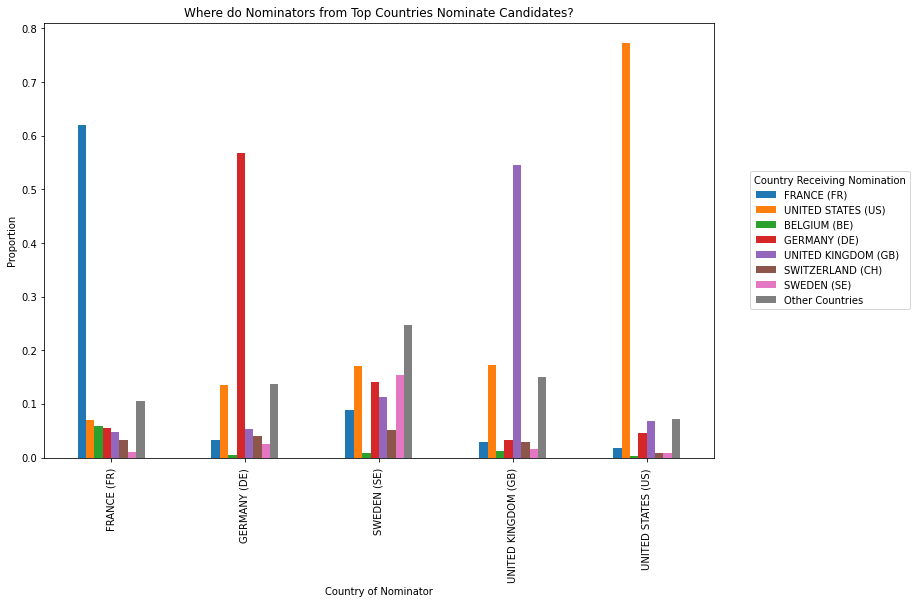

In [257]:
top_country = list(nominators['Country'].value_counts(sort=True).nlargest(n=5).index)
is_top_country = nominations['Country_nominator'].isin(top_country)
top_nom_countries = nominations[is_top_country]

top_ctry_groups = top_nom_countries.groupby('Country_nominator')
#plot top countries for nominations grouped by nominator nationality
fig, ax = plt.subplots(1,1, figsize = (12,8))

plot_areas = zip(top_ctry_groups.groups.keys(), axes.flatten()) # creates list so that I can match plotting axes with group keys when I iterate
df = pd.DataFrame()
others = []
crit_value = 0.05
countries_to_keep = []

for key, group in top_ctry_groups:
    group = top_ctry_groups.get_group(key)
    df[key] = group['Country_nominee'].value_counts(normalize = True)
    countries_to_keep.extend([idx for idx in df[key].index if df[key].at[idx] > crit_value])

countries_to_keep = np.unique(countries_to_keep) 

for key, group in top_ctry_groups:
    idx_values = zip(df[key].index.tolist(), df[key])
    other = sum([val for idx, val in idx_values if (val <= crit_value) & (idx not in countries_to_keep)])
    others.append(other)
    df.loc[(df[key] <= crit_value) & (~df.index.isin(countries_to_keep)), key] = np.nan

df = df.dropna(how = "all")
df.loc["Other Countries"] = others
df.T.sort_index().plot(kind = 'bar', legend = True, ax = ax)
ax.set_title("Where do Nominators from Top Countries Nominate Candidates?")
ax.legend(title = "Country Receiving Nomination", loc="center right", bbox_to_anchor=(1.3, 0.5))
ax.set_xlabel("Country of Nominator")
ax.set_ylabel("Proportion")
fig.savefig('where_do_nominators_from_top_countries_nominate_candidates.png', bbox_inches='tight')

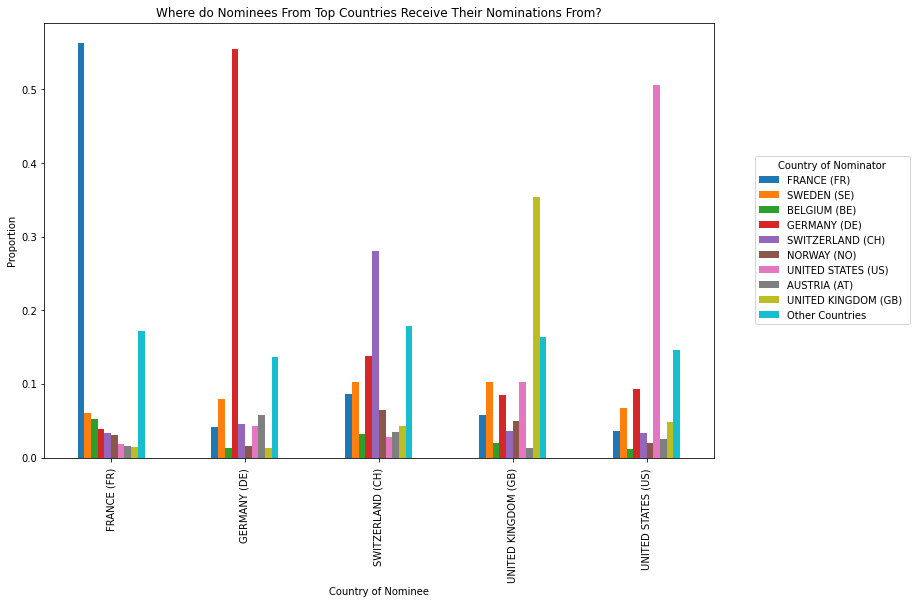

In [258]:
top_country = list(nominees['Country'].value_counts(sort=True).nlargest(n=5).index)
is_top_country = nominations['Country_nominee'].isin(top_country)
top_nom_countries = nominations[is_top_country]

top_ctry_groups = top_nom_countries.groupby('Country_nominee')
#plot top countries for nominations grouped by nominee nationality
fig, ax = plt.subplots(1,1, figsize = (12,8))

plot_areas = zip(top_ctry_groups.groups.keys(), axes.flatten()) # creates list so that I can match plotting axes with group keys when I iterate
df = pd.DataFrame()
others = []
crit_value = 0.05
countries_to_keep = []

for key, group in top_ctry_groups:
    group = top_ctry_groups.get_group(key)
    df[key] = group['Country_nominator'].value_counts(normalize = True)
    countries_to_keep.extend([idx for idx in df[key].index if df[key].at[idx] > crit_value])

countries_to_keep = np.unique(countries_to_keep) 

for key, group in top_ctry_groups:
    idx_values = zip(df[key].index.tolist(), df[key])
    other = sum([val for idx, val in idx_values if (val <= crit_value) & (idx not in countries_to_keep)])
    others.append(other)
    df.loc[(df[key] <= crit_value) & (~df.index.isin(countries_to_keep)), key] = np.nan

df = df.dropna(how = "all")
df.loc["Other Countries"] = others
df.T.sort_index().plot(kind = 'bar', legend = True, ax = ax)
ax.set_title("Where do Nominees From Top Countries Receive Their Nominations From?")
ax.legend(title = "Country of Nominator", loc="center right", bbox_to_anchor=(1.3, 0.5))
ax.set_xlabel("Country of Nominee")
ax.set_ylabel("Proportion")
fig.savefig('where_do_nominees_from_top_countries_receive_nominations.png', bbox_inches = 'tight')

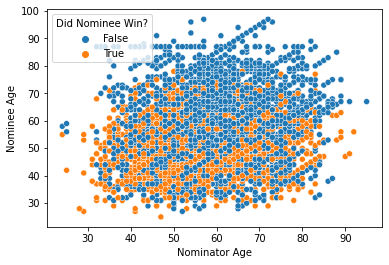

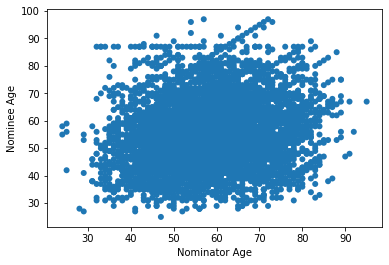

In [273]:
#scatterplot visualizing nominee age vs. nominator age

# nominations['age_nominee'] = nominations['Year, Death_nominee'] - nominations['Year, Birth_nominee']
# nominations['age_nominator'] = nominations['Year, Death_nominator'] - nominations['Year, Birth_nominator']
ages = nominators_people.merge(nominees_people, on = 'url', how = 'inner', suffixes = ['_nominator', '_nominee'])
ages = ages[['age_nominee', 'age_nominator', 'is_winner_nominee']]
# ages = pd.concat([nominators_people['age'], nominees_people['age']], axis=1, keys=['age_nominator', 'age_nominee'])

plt.figure()
ax = sns.scatterplot(x = 'age_nominator', y = 'age_nominee', data = ages, hue = 'is_winner_nominee')
# ax.set_title("Nominee Age vs. Nominator Age")
ax.legend(title = "Did Nominee Win?")
ax.set_xlabel("Nominator Age")
ax.set_ylabel("Nominee Age")
plt.savefig("nominee_vs_nominator_age_is_winner.png")

plt.figure()
ax = sns.scatterplot(x = 'age_nominator', y = 'age_nominee', data = ages, ec = None)
ax.set_xlabel("Nominator Age")
ax.set_ylabel("Nominee Age")
plt.savefig("nominee_vs_nominator_age.png")

In [72]:
# Analysis of winners
winners_people = nominees_people.loc[nominees_people['is_winner'] == True]
print(f"average number of nominations for winners: {winners['Name'].value_counts().mean()}")

average number of nominations for winners: 18.84986595174263


count    5666.000000
mean       51.715143
std         9.801780
min        25.000000
25%        45.000000
50%        51.000000
75%        59.000000
max        85.000000
Name: age, dtype: float64
count    14577.000000
mean        56.763189
std         12.127203
min         19.000000
25%         48.000000
50%         56.000000
75%         65.000000
max         97.000000
Name: age, dtype: float64


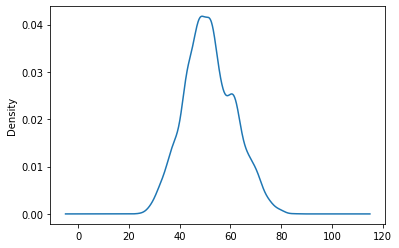

In [73]:
### age distribution of winners
winners_people['age'].plot(kind = 'density')
print(winners_people['age'].describe())
print(nominees_people['age'].describe())

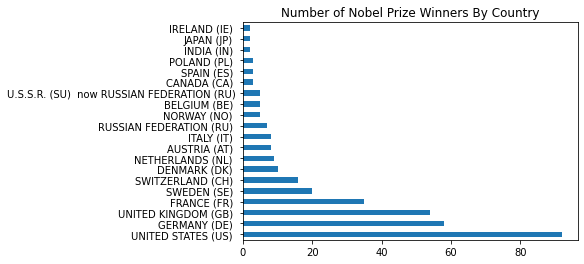

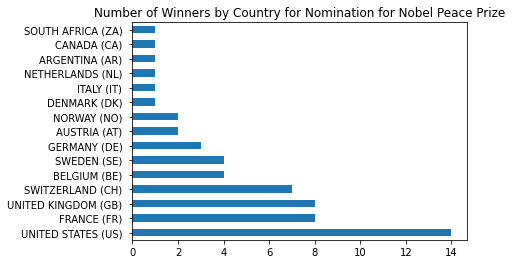

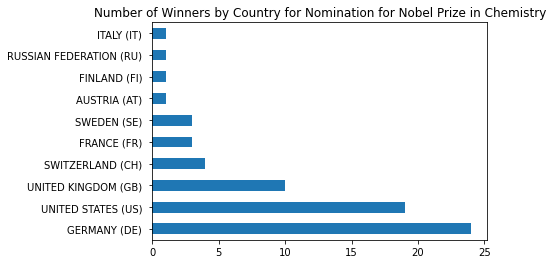

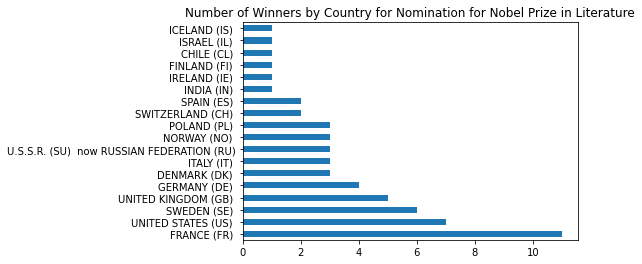

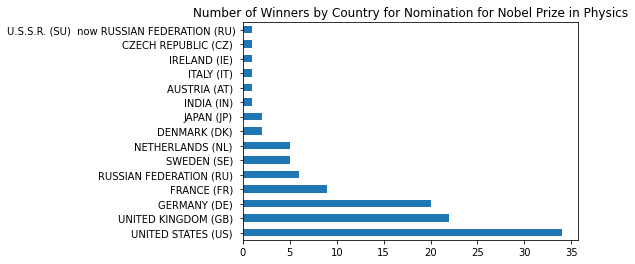

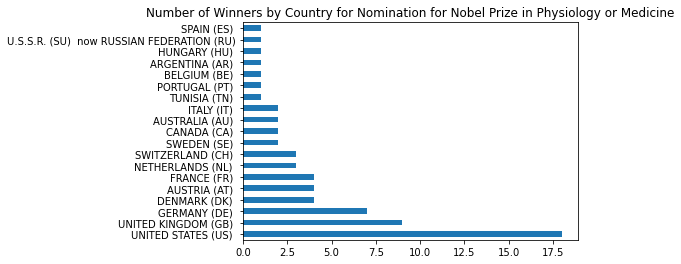

In [357]:
#most common nationalities of winners
winners = nominees.loc[nominees['is_winner'] == True]
winners = winners.drop_duplicates(subset = ["Name"])
plt.figure()
winners['Country'].value_counts().nlargest(20).plot(kind = 'barh')
plt.title("Number of Nobel Prize Winners By Country")
plt.savefig("20_most_prevalent_countries_of_nobel_prize_winners.png", bbox_inches = "tight")


grouped = winners.groupby('category')
plot_areas = zip(grouped.groups.keys(), axes.flatten())
for idx, (key, ax) in enumerate(plot_areas):
    plt.figure()
    df = grouped.get_group(key)
    df['Country'].value_counts().plot(kind = 'barh')

    plt.title(f"Number of Winners by Country for {key}")
    plt.savefig(f"number_of_winners_by_country_for_{key.lower().replace(' ', '_')}", bbox_inches = "tight")

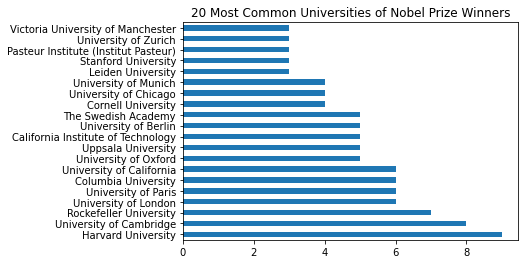

In [358]:
#Changing longer or obscure university 
winners.loc[winners['University'] == 'Berlin', 'University'] = 'University of Berlin'
winners.loc[winners['University'] == 'Vienna', 'University'] = 'University of Vienna'
winners.loc[winners['University'] == 'Sorbonne', 'University'] = 'University of Paris'
winners.loc[(winners['University'] == 'Washington'), 'University'] = 'Washington University (St. Louis)'
winners.loc[(winners['University'] == 'Rockefeller Institute for Medical Research (now  Rockefeller University)'), 'University'] = 'Rockefeller University'
winners.loc[(winners['University'].notnull()) &(winners['University'].str.contains("Swedish Academy", case = True)), 'University'] = "The Swedish Academy"

ax = winners['University'].value_counts().nlargest(20).plot(kind = 'barh')
ax.set_title('20 Most Common Universities of Nobel Prize Winners')
plt.savefig('20_most_common_universities_of_nobel_prize_winners.png', bbox_inches = "tight")

Proportion of winners for the Nomination for Nobel Peace Prize affiliated with a university listed 0.11475409836065574
Proportion of winners for the Nomination for Nobel Prize in Chemistry affiliated with a university listed 0.9558823529411765
Proportion of winners for the Nomination for Nobel Prize in Literature affiliated with a university listed 0.09375
Proportion of winners for the Nomination for Nobel Prize in Physics affiliated with a university listed 0.8053097345132744
Proportion of winners for the Nomination for Nobel Prize in Physiology or Medicine affiliated with a university listed 0.9402985074626866


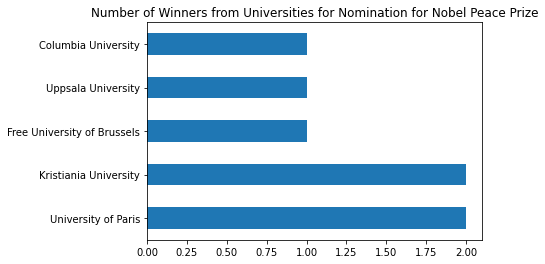

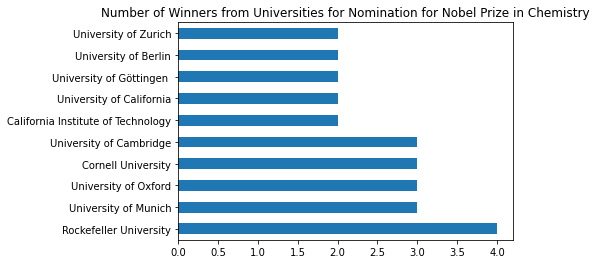

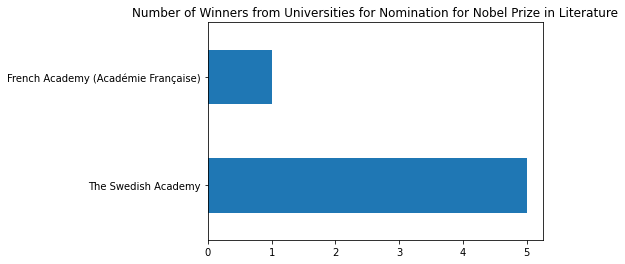

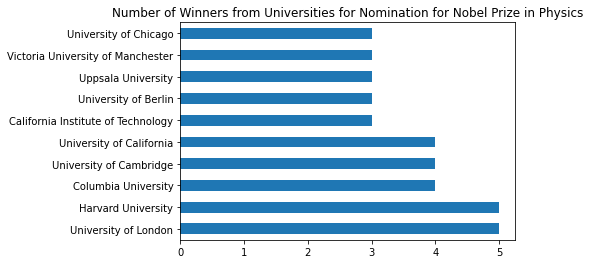

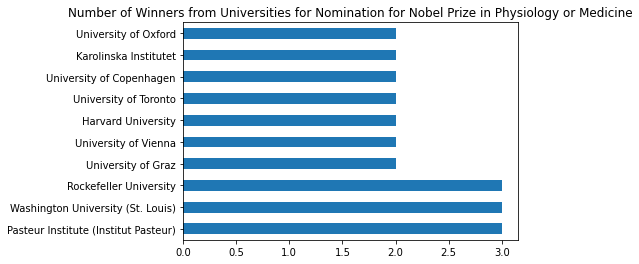

In [359]:
grouped = winners.groupby('category')

plot_areas = zip(grouped.groups.keys(), axes.flatten())
for idx, (key, ax) in enumerate(plot_areas):
    plt.figure()
    df = grouped.get_group(key)
    df['University'].value_counts().nlargest(10).plot(kind = 'barh')
    plt.title(f"Number of Winners from Universities for {key}")
    plt.savefig(f"number_of_winners_from_universities_for_{key.lower().replace(' ' , '_')}", bbox_inches = "tight" )
    print(f"Proportion of winners for the {key} affiliated with a university listed {len(df.loc[df['University'].notnull()].index)/len(df.index)}")

In [347]:
# Proportion of nominees affiliated with a university (probably explains the stark discrepancies between the counts of the maxes on these plots)

nominees_univ_affiliation = nominees.groupby('category').apply(lambda df: len(df.loc[df['University'].notnull()].index)/len(df.index)).reset_index()
winners_univ_affiliation = winners.groupby('category').apply(lambda df: len(df.loc[df['University'].notnull()].index)/len(df.index)).reset_index()
university_affiliation = nominees_univ_affiliation.merge(winners_univ_affiliation, on = 'category', how = 'inner')
university_affiliation = university_affiliation.rename(columns={"0_x": "Percentage of Nominees Affiliated With University", "0_y": "Percentage of Winners Affiliated With University"})
university_affiliation = university_affiliation.rename(columns = {'category':'Category'})

df = university_affiliation.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}]).format({
    'Percentage of Nominees Affiliated With University': '{:,.2%}'.format,
    "Percentage of Winners Affiliated With University": '{:,.2%}'.format
}).hide_index()
# dfi.export(df, 'nominee_university_affiliation.png')
df

[0121/151415.439058:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0121/151415.440232:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0121/151415.441381:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0121/151416.173790:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpyvje18n2/temp.png.


Category,Percentage of Nominees Affiliated With University,Percentage of Winners Affiliated With University
Nomination for Nobel Peace Prize,13.38%,11.48%
Nomination for Nobel Prize in Chemistry,63.09%,95.31%
Nomination for Nobel Prize in Literature,2.43%,9.38%
Nomination for Nobel Prize in Physics,58.85%,80.53%
Nomination for Nobel Prize in Physiology or Medicine,87.61%,93.44%


In [199]:
df = nominators['Name'].value_counts().nlargest(20).to_frame().reset_index()
df.columns = ["Nominator Name", "No. of Nominations Given"]
df["Proportion of Nominations Given to Eventual Winners"] = /df["No. of Nominations Given"]
df = df.style.set_table_attributes("style='display:inline'").set_caption('Top 20 Most Frequent Nominators').hide_index()
# dfi.export(df, 'most_frequent_nominators_table.png')
df

[0117/154523.303505:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/154523.304758:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0117/154523.306758:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0117/154523.996449:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmpthy7fybb/temp.png.


Nominator Name,No. of Nominations Given
Hans Wehberg,54
Knut Hjalmar Leonard Hammarskjöld,50
James Franck,42
Leopold Ruzicka,42
Max K Planck,42
Otto Hahn,37
Max von Laue,37
Glenn Theodore Seaborg,36
Hans K von Euler-Chelpin,35
Jacques Hadamard,34


[0120/151839.092833:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0120/151839.093868:ERROR:file_io.cc(94)] ReadExactly: expected 8, observed 0
[0120/151839.094999:ERROR:xattr.cc(63)] setxattr org.chromium.crashpad.database.initialized on file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/: Operation not permitted (1)
[0120/151839.761726:INFO:headless_shell.cc(653)] Written to file /var/folders/sf/z2b9zp717xb2vw6wy0l0_jh00000gn/T/tmp0xg5ll5q/temp.png.


Nominator Name,Nominee Name,Count
Robert A Millikan,Carl D Anderson,13
Lucien Le Foyer,Charles Robert Richet,11
Samuel Baart de la Faille,The Permanent International Peace Bureau,11
Carl Adolf Bodelsen,Johannes V Jensen,10
James Franck,Otto Stern,10
Niilo J Toivonen,Hermann Staudinger,9
Émile Arnaud,Henri Marie La Fontaine,9
Niilo J Toivonen,Artturi I Virtanen,9
Emil Warburg,Petrus J Debye,8
Yrjö Hirn,Frans E Sillanpää,8


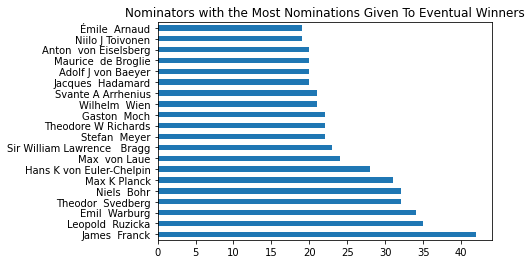

In [314]:
winning_nominations = nominations.loc[nominations['is_winner_nominee'] == True]
winning_nominations['Name_nominator'].value_counts().nlargest(20).plot(kind = 'barh')
plt.title("Nominators with the Most Nominations Given To Eventual Winners")
plt.savefig('nominators_with_the_most_nominations_given_to_eventual_winners.png', bbox_inches = "tight")

df = winning_nominations.groupby(['Name_nominator','Name_nominee']).size().to_frame().reset_index()
df.columns = ["Nominator Name", "Nominee Name", "Count"]
df = df.sort_values(by=['Count'], ascending = False)
df = df.head(20)
df_styled = df.style.set_table_styles([
        {"selector": "th", "props": [("text-align", "center")]},
        {"selector": "td", "props": [("text-align", "center")]}]).hide_index()
dfi.export(df_styled, "most_frequent_nominator_to_winner_combinations.png")
df_styled

In [318]:
conditions = winning_nominations['Name_nominator'].isin(df["Nominator Name"]) & \
    winning_nominations['Name_nominee'].isin(df["Nominee Name"])
df2 = winning_nominations.loc[conditions]
df2 = df2.groupby(['Name_nominee', 'Name_nominator'])['category'].apply(lambda x: len(np.unique(x)))
df2 = df2.to_frame()
df_filtered = df2.loc[df2['category'] > 1]
df_filtered
#this df is empty meaning that there were no nominators out of the nost frequent combinations that nominated their
# candidates for more than one different type of award


,,category
Name_nominee,Name_nominator,


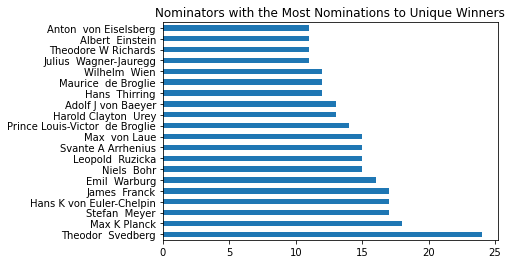

In [325]:
winning_nominations = winning_nominations.drop_duplicates(subset = ['Name_nominee', 'Name_nominator'])
winning_nominations['Name_nominator'].value_counts().nlargest(20).plot(kind = 'barh')
plt.title("Nominators with the Most Nominations to Unique Winners")
plt.savefig('nominators_with_the_most_nominations_given_to_unique_winners.png', bbox_inches = "tight")

In [ ]:
winning_nominations.groupby

In [248]:
with pd.option_context('display.max_colwidth', None):
  display(nominations.loc[(nominations['invalid_country_nominee'] == True) , ['url','category', 'Country_nominee']])

,url,category,Country_nominee
2144,https//www.nobelprize.org/nomination/archive/show.php?id=9246,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2146,https//www.nobelprize.org/nomination/archive/show.php?id=9232,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2148,https//www.nobelprize.org/nomination/archive/show.php?id=9254,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2149,https//www.nobelprize.org/nomination/archive/show.php?id=9200,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2150,https//www.nobelprize.org/nomination/archive/show.php?id=9288,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2151,https//www.nobelprize.org/nomination/archive/show.php?id=9608,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2152,https//www.nobelprize.org/nomination/archive/show.php?id=9472,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2153,https//www.nobelprize.org/nomination/archive/show.php?id=9766,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2176,https//www.nobelprize.org/nomination/archive/show.php?id=10883,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)
2188,https//www.nobelprize.org/nomination/archive/show.php?id=11169,Nomination for Nobel Prize in Physics,JAPAN (JP) UNITED STATES (US)


In [351]:
with pd.option_context('display.max_colwidth', None):
  display(winners.loc[winners["University"].notnull() & winners["University"].str.contains("Swedish", case = True), 'url'] )

897        https//www.nobelprize.org/nomination/archive/show.php?id=464
25510     https//www.nobelprize.org/nomination/archive/show.php?id=4154
25867     https//www.nobelprize.org/nomination/archive/show.php?id=7342
28224     https//www.nobelprize.org/nomination/archive/show.php?id=4868
29716    https//www.nobelprize.org/nomination/archive/show.php?id=18114
30294    https//www.nobelprize.org/nomination/archive/show.php?id=18204
Name: url, dtype: object